references

- Boundary Criticality of the 3D O(N) Model: From Normal to Extraordinary
- Extraordinary-log surface phase transition in the three-dimensional XY model

In [80]:
from opt_einsum import contract
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
import importlib
import HOTRGZ2,TNModels
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
from TNModels import Ising3D,Ising2D,Models
from HOTRGZ2 import HOTRG_layers,forward_observable_tensor,trace_tensor,trace_two_tensors,forward_observalbe_tensor_moments,forward_observable_tensors

# Try HOTRG Ising3D

In [142]:
params=torch.load('./data/ising3d_hotrg_X8_Tc')
print(params)
model=Ising3D(params)
T0=model.get_T0()
layers,Ts,logTotals=HOTRG_layers(T0,max_dim=8,nLayers=30,return_tensors=True)

{'beta': 0.22138627052307125}
Generating HOTRG layers


  0%|          | 0/30 [00:00<?, ?it/s]

HOTRG layers generated


In [140]:
filename='./data/ising3d_hotrg_X10_corr'
T0_op,checkerboard=model.get_observables()['magnetization']
data=[]
for r in tqdm(np.geomspace(2,1023,32)):
    theta=np.random.uniform(0,.5*np.pi)
    phi=np.random.uniform(0,.5*np.pi)
    dx,dy,dz=int(r*np.sin(theta)*np.cos(phi)),int(r*np.sin(theta)*np.sin(phi)),int(r*np.cos(theta))
    x1,y1,z1=np.random.randint(0,1024-dx),np.random.randint(0,1024-dy),np.random.randint(0,1024-dz)
    x2,y2,z2=x1+dx,y1+dy,z1+dz
    T,T_op,logTotal=forward_observable_tensors(T0,[T0_op,T0_op],[(x1,y1,z1),(x2,y2,z2)],layers,cached_Ts=Ts,user_tqdm=False)
    corr=trace_tensor(T_op)/trace_tensor(T)
    data.append({'corr':corr.item(),
                 'x1':x1,'y1':y1,'z1':z1,
                    'x2':x2,'y2':y2,'z2':z2,
    })
# save 
torch.save(data,filename)


  0%|          | 0/32 [00:00<?, ?it/s]

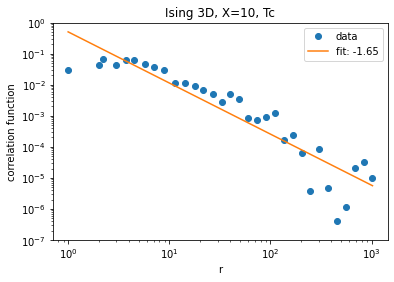

In [141]:
curve=pd.DataFrame(torch.load('./data/ising3d_hotrg_X10_corr'))
curve['r']=np.sqrt((curve['x1']-curve['x2'])**2+(curve['y1']-curve['y2'])**2+(curve['z1']-curve['z2'])**2)

import scipy.stats
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(np.log(curve['r']),np.log(np.abs(curve['corr'])))


plt.plot(curve['r'],np.abs(curve['corr']),'o',label='data')
plt.plot(curve['r'],np.exp(intercept)*curve['r']**slope,label=f'fit: {slope:.2f}')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('correlation function')
plt.ylim([1e-7,1])
plt.title('Ising 3D, X=10, Tc')
plt.show()

In [95]:

from HOSVD import _HOSVD_layer_3D,gauge_invariant_norm

In [98]:
def _XTRG_layer_3D(Ta,Tb,max_dim):
    Tn,layer=_HOSVD_layer_3D(Ta,Tb,max_dim=max_dim)
    Tn=contract('abcdio->ioabcd',Tn)
    return Tn,layer

def XTRG_3D_defect(T0,T0_def,max_dim,nLayers):
    T,T_op,logTotal=T0,T0_def,0
    for i in tqdm(range(nLayers),leave=False):
        norm=gauge_invariant_norm(T)
        logTotal=2*(logTotal+norm.log())
        T,T_op=T/norm,T_op/norm
        T_op=_XTRG_layer_3D(T_op,T,max_dim=max_dim)[0]
        T=_XTRG_layer_3D(T,T,max_dim=max_dim)[0]
    return T,T_op

T,T_def=XTRG_3D_defect(T0,T0_op,max_dim=16,nLayers=20)

  0%|          | 0/20 [00:00<?, ?it/s]